## Uncertainty Quantifications - Monte Carlo Simulations

---

This notebook will quantify log k values for various species using a Monte Carlo method with lower and upper bounds from literature. See below:

Mahoney et al. (2009). Uranyl Adsorption on to Hydrous Ferric Oxcide--A Re-Evaluation for the Diffuse Layer Model Database. *Environmental Science and Technology,* *43*(24), 9263. doi: 10.1021/es901586w

#### Set up initial parameters and uncertainty bounds

*pqcpath*: path to phreeqc.bat executable

*TDBfile*: name of phreeqc database file without file extension

*outfile*: name of phreeqc output file including file extension

*infile*: name of phreeqc input file including file extension

In [1]:
import os 
import numpy.random
from writeIOphreeqc import*
import matplotlib.pyplot as plt

# these are used when we run phreeqc in MC_sim()
pqcpath = 'C:/Users/htzen/Desktop/phreeqc-3.7.0-15749-x64/bin/phreeqc'
TDBfile = 'llnl_Mahoney_updated'
outfile = 'Outputfile3.out'
infile = 'U_HFO_input3.txt'

# bounds from table 2 in Mahoney et. al.
pars    = ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!']
lower = [1.62, 1.79, 8.75, 15.1]
upper = [5.85, 3.28, 9.32, 15.28]


# extraneous verify function which can be a simple sanity check for longer lists
def verify(low, upp):
    """
    checks length and bounds of lists for correct format
    """
    if len(low) == len(upp):
        
        if all([low[i] <= upp[i] for i in range(len(low))]):
            print("verify: bounds check out")
            return True
        print("verify: error -- listed bounds are inconsistent")
        return False
    
    print("verify: error -- lists are different lenghts")
    return False



# searches for the '-find ' key in the input file to get the name of the .sel output file
# (assumes .sel file is in the current directory)
def find_opsel(infile):
    
    with open(infile, 'r') as f:
        for line in f.readlines():
            if line.find("-file ") > 0:
                return line[line.find("-file ")+len("-file "):-1]
            
    print("error: unable to find output file in {}".format(infile))
    return -1


#### Define methods for Monte Carlo simulation

In a Monte Carlo simulation we will generate random values for the parameters within the upper/lower bounds for each run

In [3]:
# returns a matrix of random values between lower and upper
def get_random_values(lower, upper, num_iter):
    # lower, upper: lists of bounds to generate within
    # num_iter: number of sets to generate
    # return: num_iter by len(lower) matrix
    
    # generate 1 row
    matrix = np.zeros(len(lower))
    for i in range(len(lower)):
        matrix[i] = numpy.random.uniform(lower[i], upper[i])
        
    # generate more rows if needed
    if num_iter < 2:
        return [matrix]
    else:
        for j in range(num_iter-1):
            values = np.zeros(len(lower))
            for i in range(len(lower)):
                values[i] = numpy.random.uniform(lower[i], upper[i])
            matrix = np.vstack((matrix, values))
        return matrix

# runs x phreeqc simulations where x is the height of values_mtrx
# requires various path variables to be set correctly at beginning of file
def MC_sim(values_mtrx, opsel, analytes=['pH', 'U']):
    # values_mtrx: matrix of values generated from get_random_values or similar function
    # analytes: list of element keywords to search for in .out file generated by phreeqc
    # opsel: path to the .sel file  
    # return: list of np arrays of [sim#, analyte1, analyte2...] (format is kind of awkward 
    #    but I can handle it with wrapper functions for now)
    
    obs_all = []
    for values in values_mtrx:        
        # enabling the below code can help verify phreeqc is correctly generating new output files
        # by deleting old output files before each run
#         if os.path.exists("Outputfile.out"):
#             os.remove("Outputfile.out")
#         if os.path.exists("U_HFO_Complexation_Output_Trial3.sel"):
#             os.remove("U_HFO_Complexation_Output_Trial3.sel")

        writeInput(TDBfile, pars, values)
        
        # the .read() here is essential because it tells python to wait for phreeqc to
        # finish running before executing following code.
        os.popen(pqcpath+' '+infile+' '+outfile+' '+TDBfile+'.txt').read()
        
        # reads phreeqc results and appends to running list
        obs = readOutput(opsel, analytes)
        obs_all.append(obs)

        # enabling following code can help check if the output files are updating correctly
#         import shutil
#         shutil.copyfile('U_HFO_Complexation_Output_Trial3.sel', 'U_HFO_Complexation_Output_Trial3_{}.sel'.format(itr))
#         shutil.copyfile('llnl_Mahoney_updated.txt', 'llnl_Mahoney_updated{}.txt'.format(itr))

    return obs_all


In [4]:
# verify bounds and set phreeqc output to read
verify(lower, upper)
opsel = find_opsel(infile)
#print(opsel)
gen_values = get_random_values(lower, upper, 9)
res = MC_sim(gen_values, opsel)

verify: bounds check out


In [5]:
res

[array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.9201e-08, 9.2774e-08, 6.4406e-08, 1.9844e-08, 5.4631e-09,
         3.0953e-09]]),
 array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.7494e-08, 7.8896e-08, 3.4346e-08, 6.6728e-09, 1.6415e-09,
         9.1484e-10]]),
 array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.3568e-08, 5.7803e-08, 1.6061e-08, 2.5476e-09, 6.0647e-10,
         3.3647e-10]]),
 array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400

#### Plotting + Residual Sum of Squares Analysis with Experimental Results

For each run from MC_sim that we did we can plot pH vs Uranium concentrations in micromoles, and compare to experimental results to find the run with the least RSS value

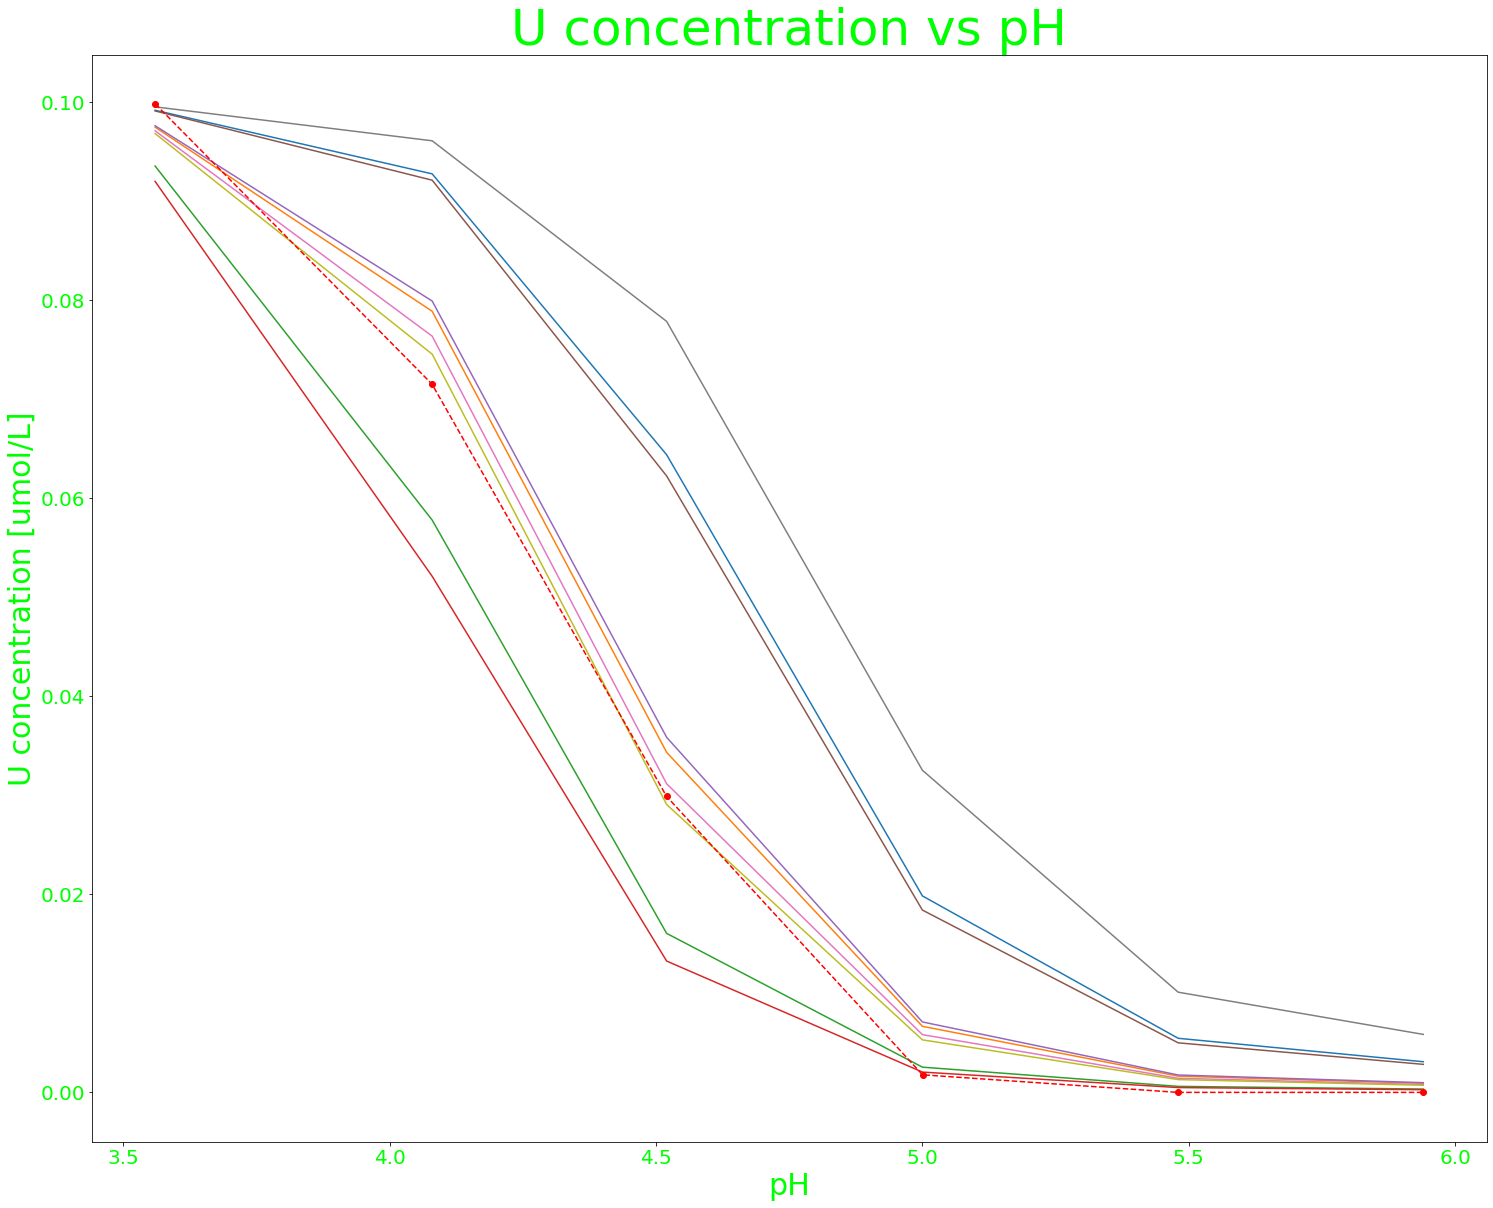

In [6]:
f = plt.figure(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("U concentration vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('U concentration [umol/L]', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

# setting up values from experimental results
exp_pH = [3.56041,4.07969,4.51985,5.00029,5.47929,5.93959]
exp_U = [0.099831,0.071537,0.029899,0.001774,0,0]

# plotting each data from MC_sim
for run in res:
    # hard coding in plots for pH and U
    plt.plot(run[1], run[2]*1e6)

# plotting experimental results
plt.plot(exp_pH, exp_U, 'r--o')

plt.show()

For RSS analysis I think the best thing to do in this situation is to just hard-code something instead of making more comprehensive functions, since the experimental data in this case seems tailor-fit for this specific scenario. I will iterate through the list of results and find a quick residual sum of squares for each pH (approximating the pHes because they're already really close)

In [7]:
rss_list = []

for run in res:
    # rss is Sum((expected - observed)^2)
    rss = np.sum(np.square(exp_U - run[2]*1e6))
    rss_list.append(rss)

bestrun = rss_list.index(min(rss_list))
bestfit = res[rss_list.index(min(rss_list))][2]
bestanalytes = gen_values[bestrun]

print(rss_list)
print(min(rss_list), bestrun)
print("The best fitting analytes are: {} from run {}.".format(bestanalytes, bestrun))

# write a new .tpl file with the best fit analyte values
writeInput(TDBfile, pars, bestanalytes, TDBfile+"_MCnew")

[0.0020080913617, 0.0001069219549155999, 0.00042041764388180006, 0.0007150843327064997, 0.00014338140996439995, 0.0017820620275999998, 5.1551127688100024e-05, 0.00398883865856, 3.338969368960009e-05]
3.338969368960009e-05 8
The best fitting analytes are: [ 1.84525835  2.87268232  8.88644935 15.26978932] from run 8.


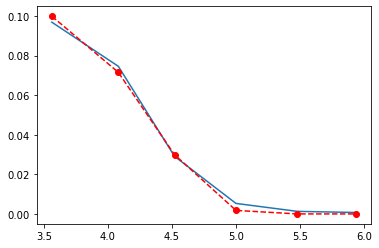

In [8]:
plt.plot(res[0][1], bestfit*1e6, exp_pH, exp_U, 'r--o')
plt.show()

#### Sensitivity Analysis

We will use the morris analysis functions from the Sensitivity Analysis Library package to find which of the four initial parameters are the most significant

---
large mean (mu) = large response to perturbation

large sigma = elementary effects depend highly on choice of sample point (response is non-linear)

small sigma = EEs similar for different selected sample points; effect of parameter independent of other parameter values

In [13]:
from SALib.sample import morris as ssm
from SALib.analyze import morris as sam

# Define the model inputs
problem = {
    'num_vars': 4,
    'names': ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!'],
    'bounds': [[1.62, 5.85], [1.79, 3.28], [8.75, 9.32], [15.2, 15.28]]
}


# runs MC_sim and formats results into matrix for use with morris functions
def morris_MC_sim(params, opsel, analyte=['U']):
    # analyte: single analyte to measure; name of colummn from phreeqc .sel output file
    # return: #simulations by #observations matrix

    sims = MC_sim(params, opsel, analyte)
    
    # [0][1] index of MC_sim will be the list of analyte values 
    morris_output = sims[0][1]
    for sim in sims[1:]:
        morris_output = np.vstack((morris_output, sim[1]))
    
    return morris_output

# generates a matrix of observations by parameters
def morris_gen_mu(X, Y):
    # Perform Morris analysis on parameter 1
    morris_result = [sam.analyze(problem, X, Y.T[0], conf_level=0.95, num_levels=4,
                         print_to_console=False)]

    # Storing the sensitivity indices as a list of dictionaries
    # each dictionary represents the results for one observation
    # returning this list instead gets a lot more information, but it might not
    # be necessary for now
    for i_obs in range(1, np.shape(Y)[1]):
        Si = sam.analyze(problem, X, Y.T[i_obs], conf_level=0.95, num_levels=4, 
                         print_to_console=False)
        morris_result.append(Si)

    # Making a matrix of observations by parameters
    mu_all = morris_result[0].get("mu")
    for obs in morris_result[1:]:
        mu_all = np.vstack((mu_all, obs.get("mu")))
        
    return mu_all

In [16]:
# Generate samples according to the morris method
# in this case it's 20*(num_vars+1) sets of 4 parameters within the bounds
X = ssm.morris.sample(problem, 20)

# Calculate model outputs
%timeit -n1 -r1 Y = morris_MC_sim(X, opsel)

# generate results
mu_all = morris_gen_mu(X, Y)

3min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [17]:
mu_all

array([[ 4.75230000e-09, -3.11160000e-09, -6.47325000e-09,
         8.48970000e-09],
       [ 4.48305000e-09, -7.94122500e-09, -1.32674250e-08,
         1.09473750e-08],
       [ 3.69834750e-09, -1.12461825e-08, -9.50455500e-09,
         2.35089750e-09],
       [ 3.64602150e-09, -6.67226250e-09, -1.60378950e-09,
        -1.33396500e-10],
       [ 1.37859443e-09, -2.31096593e-09, -2.28526500e-10,
        -7.52685000e-11],
       [ 8.22095175e-10, -1.35943103e-09, -1.08584850e-10,
        -4.51683000e-11]])

from a youtube video https://www.youtube.com/watch?v=P8Rfipkid3w:

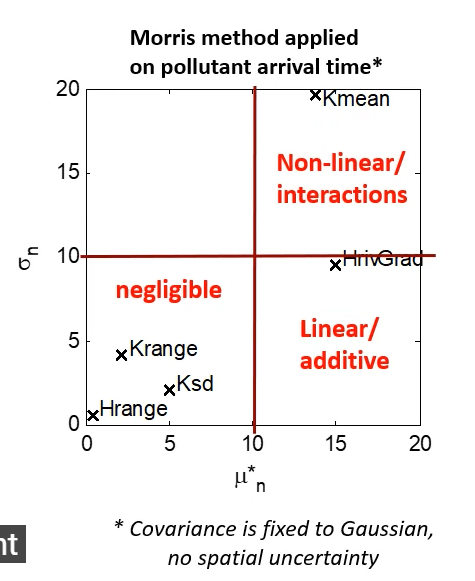



Now we will use the sobol method from the same library

In [18]:
from SALib.sample import saltelli as sss
from SALib.analyze import sobol as sas

def sobol_MC_sim(params, opsel, analyte=['U']):
    # analyte: single analyte to measure; name of colummn from phreeqc .sel output file
    # return: #simulations by #observations matrix

    sims = MC_sim(params, opsel, analyte)
    
    # [0][1] index of MC_sim will be the list of analyte values 
    sobol_output = sims[0][1]
    for sim in sims[1:]:
        sobol_output = np.vstack((sobol_output, sim[1]))
    
    return sobol_output

def sobol_gen_mu(X, Y):
    # Perform sobol analysis on parameter 1
    sobol_result = [sas.analyze(problem, Y.T[0], conf_level=0.95, print_to_console=False)]

    # Storing the sensitivity indices as a list of dictionaries
    # each dictionary represents the results for one observation
    # returning this list instead gets a lot more information, but it might not
    # be necessary for now
    for i_obs in range(1, np.shape(Y)[1]):
        Si = sas.analyze(problem, Y.T[i_obs], conf_level=0.95, print_to_console=False)
        sobol_result.append(Si)

    # Making a matrix of observations by parameters
#     mu_all = sobol_result[0].get("mu")
#     for obs in sobol_result[1:]:
#         mu_all = np.vstack((mu_all, obs.get("mu")))
        
    return sobol_result

In [20]:
X = sss.sample(problem, 16)
%timeit -n1 -r1 Y = sobol_MC_sim(X, opsel)
sr = sobol_gen_mu(X, Y)

6min 8s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [22]:
np.shape(X)

(160, 4)

In [21]:
sr

[{'S1': array([0.48441155, 0.38202609, 0.51455685, 0.51551123]),
  'S1_conf': array([1.66898337, 1.67931575, 1.82080294, 1.82686106]),
  'ST': array([0.87275393, 0.88263604, 1.15717723, 1.06582703]),
  'ST_conf': array([3.50068235, 3.50961543, 3.36298576, 3.82241323]),
  'S2': array([[        nan, -0.69552843, -0.81017621, -0.81048013],
         [        nan,         nan, -0.64016844, -0.64361161],
         [        nan,         nan,         nan, -0.37831409],
         [        nan,         nan,         nan,         nan]]),
  'S2_conf': array([[       nan, 2.0105125 , 1.94893017, 1.86434409],
         [       nan,        nan, 1.9094524 , 1.81886911],
         [       nan,        nan,        nan, 1.28895708],
         [       nan,        nan,        nan,        nan]])},
 {'S1': array([0.44537991, 0.05283348, 0.29266037, 0.33537611]),
  'S1_conf': array([0.9200249 , 1.13744476, 1.07002768, 0.84443944]),
  'ST': array([1.05611362, 1.18422926, 1.34069588, 1.00919946]),
  'ST_conf': array([